### finding the best parameter

In [ ]:
import numpy as np
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.randn(m, 1)


In [ ]:
# Method-1: by using 'normal function' to calculate 'best_theta:  θ_0 and θ_1'
from sklearn.preprocessing import add_dummy_feature
X_b = add_dummy_feature(X) #
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

# make predictions
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

In [ ]:
# Method-2: linear regression using Scikit-Learn
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
#lin_reg.intercept_, lin_reg.coef_  #  4.21509616 and 2.77011339
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

#####Method-3:Gradient descent

batch gradient descent

In [ ]:
eta = 0.1 # learning rate
n_epochs = 1000 # number of iterations over the training set
m = len(X_b) # number of instances
np.random.seed(42)
theta = np.random.randn(2, 1) # randomly initialized model parameters
for epoch in range(n_epochs):
  gradients = 2 / m * X_b.T @ (X_b @ theta - y)
  theta = theta - eta * gradients
theta

array([[4.21509616],
       [2.77011339]])

stochastic gradient descent using 'learning schedule' function

In [ ]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters
def learning_schedule(t):
  return t0 / (t + t1)
np.random.seed(42)
theta = np.random.randn(2, 1) # random initialization
for epoch in range(n_epochs):
  for iteration in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index : random_index + 1]
    yi = y[random_index : random_index + 1]
    gradients = 2 * xi.T @ (xi @ theta - yi) # for SGD, do not divide by m
    eta = learning_schedule(epoch * m + iteration)
    theta = theta - eta * gradients

theta

array([[4.21076011],
       [2.74856079]])

##### linear regression using stochastic GD with default learning schedule

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

#####polynomial regression using linear rigression model

In [ ]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_



(array([1.78134581]), array([[0.93366893, 0.56456263]]))

### deciding how complex model should be; and knowing whether model is overfitting or underfitting

##### learning_curve():  to train and evaluate the model using cross-validation

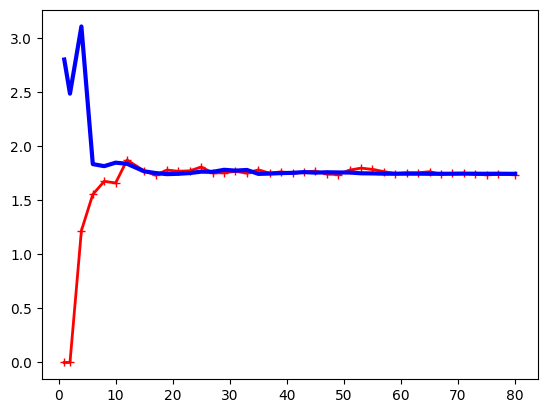

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.show()


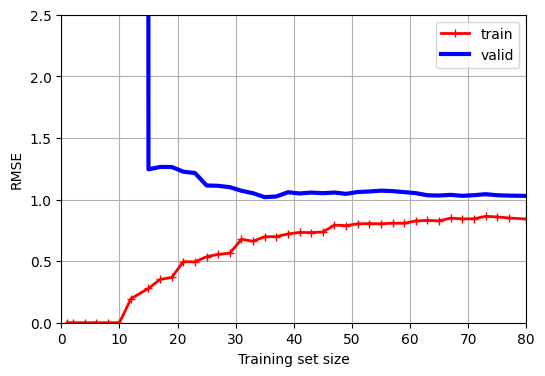

In [ ]:
from sklearn.pipeline import make_pipeline

#changing linear to polynomial by using 'PolynomialFeatures()'
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])

plt.show()


### regularization techniques

####ridge regression

##### 1.ridge regression by computing a closed-form equation: `default ridge regreesion`

In [ ]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])


array([[4.82899748]])

##### 2.ridge regression using stochastic gradient descent

In [ ]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])


array([4.82830117])

#### lesso regression

In [ ]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])


array([4.77621741])

#### elastic net regressiom

In [ ]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

## `early stop` to stop training as soon as the validation error reaches a minimum

In [ ]:
from copy import deepcopy # for copting a model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train, y_train, X_valid, y_valid = [...] # split your dataset
preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),StandardScaler())

X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)

n_epochs = 500
best_valid_rmse = float('inf')
for epoch in range(n_epochs):
  sgd_reg.partial_fit(X_train_prep, y_train)
  y_valid_predict = sgd_reg.predict(X_valid_prep)
  val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
  if val_error < best_valid_rmse:
    best_valid_rmse = val_error
    best_model = deepcopy(sgd_reg)


ValueError: not enough values to unpack (expected 4, got 1)

## Logistic regressrion

In [ ]:
# load the dataset
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
list(iris)

### to get additional info
# iris.data.head
# iris.target.head
# iris.target_names  and so on ...

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [ ]:
# split the data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

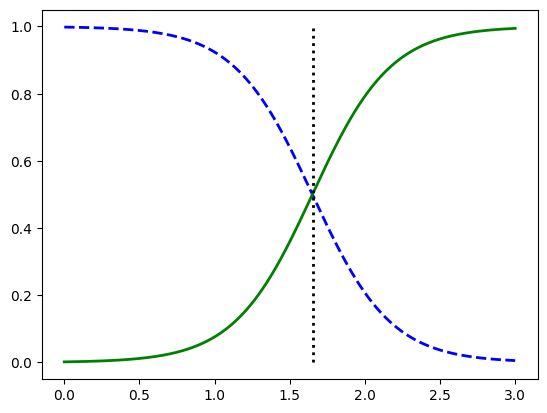

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,label="Not virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2, label="Decision boundary")

plt.show()

In [ ]:
decision_boundary

1.6516516516516517